In [3]:
%%capture
%pip install requests
%pip install pandas
%pip install matplotlib

import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

page_size = 1000 # max page size

In [25]:
maker_subgraph_url = 'https://api.thegraph.com/subgraphs/name/protofire/maker-protocol'




with open("getMakerVault.graphql", "r") as file:
    get_maker_vault_query = file.read()

# Define the DataFrame columns
df_columns = ['block_number', 'debt', 'collateral',  'price_value']
# dataframe = pd.DataFrame(columns=df_columns)
data_rows = []

days = 30
for i in range(days):
    block_number = 18015885 + i * 300 * 24

    # Variables to be passed to the query
    variables = {
        "vaultId": "0x655e761c941cdbae43514f65e57865f9bc3f54ab-ETH-A",
        "blockNumber": block_number
    }


    r = requests.post(maker_subgraph_url, json={'query': get_maker_vault_query, 'variables': variables})
    vault_data = r.json()

    # Check if the response contains data
    if 'data' in vault_data and 'vaults' in vault_data['data'] and len(vault_data['data']['vaults']) > 0:
        # Extract the data for the DataFrame
        for vault in vault_data['data']['vaults']:
            row = {
                'block_number': block_number,
                'debt': vault['debt'],
                'collateral': vault['collateral'],
                'price_value': vault['collateralType']['price']['value'],
            }
            data_rows.append(row)

df = pd.DataFrame(data_rows, columns=df_columns)
df.head()



,block_number,debt,collateral,price_value
0,18015885,134815.943556614875711971,133.026273170510934797,1644.92
1,18023085,134815.943556614875711971,133.026273170510934797,1734.24
2,18030285,134815.943556614875711971,132.026273170510934797,1700.795
3,18037485,134815.943556614875711971,132.026273170510934797,1654.4270875
4,18044685,124609.408443172453772318,125.026273170510934797,1622.62


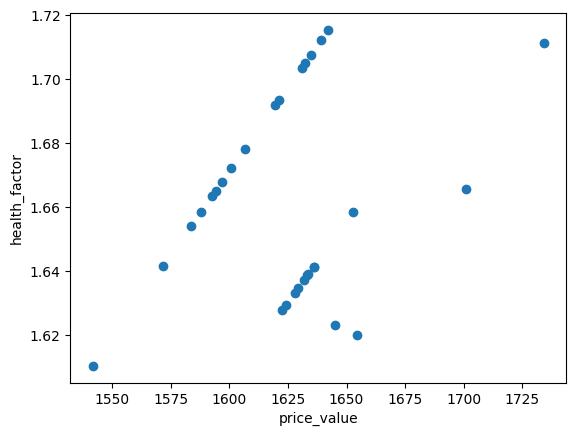

In [26]:
df['price_value'] = df['price_value'].astype(float)
df['return'] = df['price_value'].pct_change()
df['total_collateral'] = df['collateral'].astype(float) * df['price_value']
df['health_factor'] = df['total_collateral'] / df['debt'].astype(float)

df.shape
df.head()

# plot scatterplot x = price_value and y = health_factor
plt.scatter(df['price_value'], df['health_factor'])
plt.xlabel('price_value')
plt.ylabel('health_factor')
plt.show()




In [31]:
import random
print(df.head())

def monte_carlo_var(returns, num_simulations, holding_period, alpha):
    mean_return = returns.mean()
    std_return = returns.std()

    simulated_end_price = []
    for _ in range(num_simulations):
        price = 1 
        for _ in range(holding_period):
            price *= 1 + random.gauss(mean_return, std_return) 
        simulated_end_price.append(price)

    simulated_end_price = pd.Series(simulated_end_price)
    losses = 1 - simulated_end_price

    var = losses.quantile(alpha)

    return var


# params
num_simulations = 10000
holding_period = 1
alpha = 0.05

# run monte carlo simulation
monte_carlo_var = monte_carlo_var(
    df["return"], num_simulations, holding_period, alpha
)
print("Monte Carlo VaR estimate: ", monte_carlo_var)

   block_number                       debt              collateral  \
0      18015885  134815.943556614875711971  133.026273170510934797   
1      18023085  134815.943556614875711971  133.026273170510934797   
2      18030285  134815.943556614875711971  132.026273170510934797   
3      18037485  134815.943556614875711971  132.026273170510934797   
4      18044685  124609.408443172453772318  125.026273170510934797   

   price_value    return  total_collateral  health_factor  
0  1644.920000       NaN     218817.577264       1.623084  
1  1734.240000  0.054301     230699.483983       1.711218  
2  1700.795000 -0.019285     224549.625277       1.665601  
3  1654.427087 -0.027262     218427.842595       1.620193  
4  1622.620000 -0.019225     202870.131372       1.628048  
Monte Carlo VaR estimate:  -0.030816679379724276


In [ ]:
let liquidation